In [31]:
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.interval.function_providers import (NormalModesProvider, BumpFunctionProvider)
from pygeoinf.interval.operators import SOLAOperator, LaplacianInverseOperator
from pygeoinf.gaussian_measure import GaussianMeasure
from pygeoinf.interval.l2_functions import Function
from pygeoinf.interval.boundary_conditions import BoundaryConditions
from pygeoinf.bayesian import LinearBayesianInference
from pygeoinf.forward_problem import ForwardProblem
from pygeoinf.linear_solvers import CholeskySolver

import numpy as np
import matplotlib.pyplot as plt

In [56]:
function_domain = IntervalDomain(0, 1)
N = 20 # DOF of the discretized model space
basis_type = 'sine'  # Specify basis type for Sobolev space
M = L2Space(N, function_domain, basis_type=basis_type) # Continuous model space
N_d = 100
D = EuclideanSpace(N_d)
N_p = 3
P = EuclideanSpace(N_p)

RANDOM_STATE = 42
sensitvity_function_provider = NormalModesProvider(M, random_state=RANDOM_STATE, n_modes_range=(1, 5),
                                                   coeff_range=(-1, 1), freq_range=(1, 5),
                                                   gaussian_width_percent_range=(20, 50))
G = SOLAOperator(M, D, function_provider=sensitvity_function_provider, random_state=RANDOM_STATE)
centers = np.array([0.2, 0.5, 0.8])
target_kernel_provider = BumpFunctionProvider(M, default_width=0.2, centers=centers, default_k=0.0)
T = SOLAOperator(M, P, function_provider=target_kernel_provider, random_state=RANDOM_STATE)

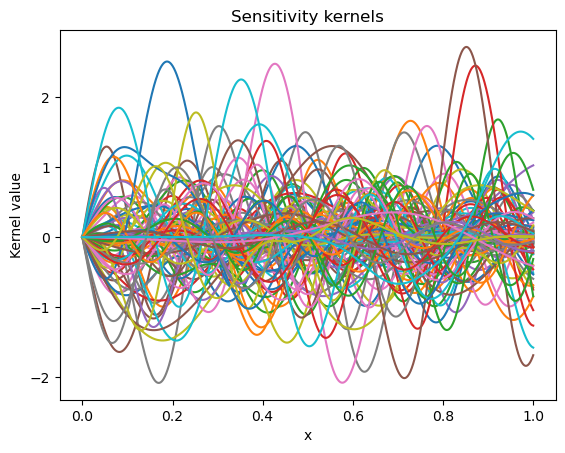

In [57]:
x_viz = function_domain.uniform_mesh(1000)
for i in range(N_d):
    plt.plot(x_viz, G.get_kernel(i)(x_viz), label=f"Kernel {i+1}")
plt.xlabel("x")
plt.ylabel("Kernel value")
plt.title("Sensitivity kernels")
plt.show()

In [58]:
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
d_bar = G(m_bar)

rng = np.random.default_rng(RANDOM_STATE)
d_std = 0.1 * np.max(np.abs(d_bar))  # Scale noise based on the maximum absolute value of d_bar
d_tilde = d_bar + rng.normal(0, d_std, size=d_bar.shape)

d_std_assumed = 0.1 * np.max(np.abs(d_tilde))  # Use a smaller assumed noise for better posterior
C_D = d_std_assumed**2 * np.eye(d_bar.shape[0])
mu_D = GaussianMeasure.from_covariance_matrix(D, C_D, expectation=d_tilde)
mu_eta = GaussianMeasure.from_covariance_matrix(D, C_D)

In [59]:
# Check the values of C_D because they might be too small
print(np.max(np.abs(C_D)))

0.0009188337741760339


In [60]:

m_0 = Function(M, evaluate_callable=lambda x: x)
bcs = BoundaryConditions(bc_type='dirichlet', left=0.0, right=0.0)
C_0 = LaplacianInverseOperator(M, bcs, alpha=0.1, solver_type='native')
M.create_gaussian_measure('kl', covariance=C_0, expectation=m_0, kl_expansion=100)


LaplacianInverseOperator initialized with native solver, dirichlet(left=0.0, right=0.0) BCs


In [61]:
fw_problem = ForwardProblem(G, mu_eta)
inference_problem = LinearBayesianInference(fw_problem, M.gaussian_measure, T)

solver = CholeskySolver()
mu_M = inference_problem.model_posterior_measure(d_tilde, solver)
mu_P = inference_problem.property_posterior_measure(d_tilde, solver)

mu_M_N = GaussianMeasure.from_covariance_matrix(M, mu_M.covariance.matrix(dense=True), expectation=mu_M.expectation)

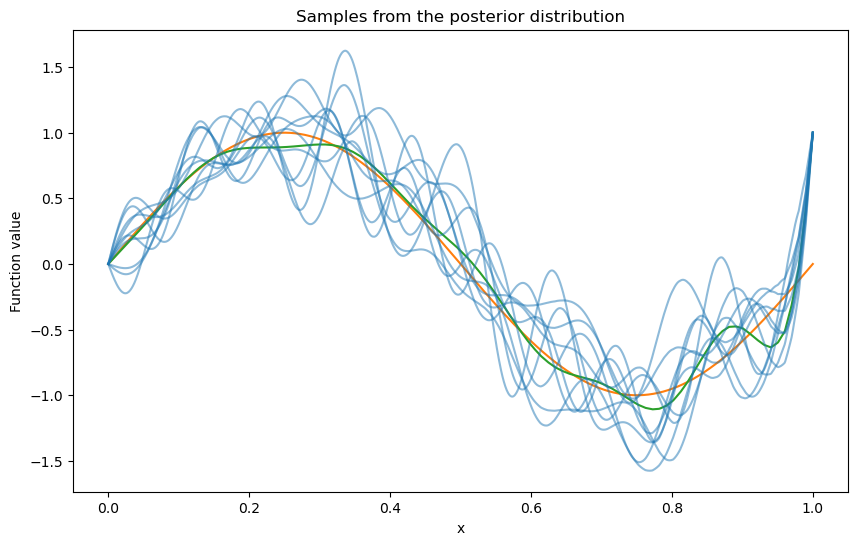

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(x_viz, m_bar(x_viz), label="True model", color='tab:orange')
plt.plot(x_viz, mu_M.expectation(x_viz), label="Posterior expectation", color='tab:green')
for i in range(10):
    sample = mu_M_N.sample()
    plt.plot(x_viz, sample(x_viz), label=f"Sample {i+1}", color='tab:blue', alpha=0.5)
plt.xlabel("x")
plt.ylabel("Function value")
plt.title("Samples from the posterior distribution")
plt.show()

In [63]:
C_P_N = mu_P.covariance.matrix(dense=True)

In [64]:
print("Posterior covariance matrix C_P_N:")
print(C_P_N)

Posterior covariance matrix C_P_N:
[[0.0086436  0.01087234 0.00750149]
 [0.01080079 0.02328332 0.01724961]
 [0.00752506 0.01749124 0.02176667]]
